In [35]:
# Cell 1 — Imports & parameters
import re, csv, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Parameters you can change
ARFF_PATH = "dataset.arff" 
TS_COLUMN = "PM2.5"          
ARIMA_P_RANGE = range(0,3)  
ARIMA_D_RANGE = range(0,2)  
ARIMA_Q_RANGE = range(0,3)  
MAX_ARIMA_FITS = 50         
SEASONAL_PERIOD_FALLBACK = 12 
plt.rcParams['figure.figsize'] = (9,4)


In [36]:
# Cell 2 — Robust ARFF loader (scipy -> liac -> manual fallback)
def load_arff_best_effort(path):
    # Try scipy first (fast, but fails on string attributes sometimes)
    try:
        from scipy.io import arff as scipy_arff
        data, meta = scipy_arff.loadarff(path)
        df = pd.DataFrame(data)
        df.columns = [c.decode() if isinstance(c, bytes) else c for c in df.columns]
        print("Loaded with scipy.io.arff")
        return df
    except Exception as e:
        print("scipy loader failed:", e)

    # Try liac-arff
    try:
        import arff as liac_arff
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            dataset = liac_arff.load(f)
        cols = [a[0] for a in dataset['attributes']]
        df = pd.DataFrame(dataset['data'], columns=cols)
        print("Loaded with liac-arff")
        return df
    except Exception as e:
        print("liac-arff loader failed:", e)

    # Manual fallback parser (best-effort)
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = [ln.rstrip('\n') for ln in f]

    data_idx = None
    for i, ln in enumerate(lines):
        if ln.strip().lower().startswith('@data'):
            data_idx = i
            break
    if data_idx is None:
        raise RuntimeError("No @data section found in ARFF.")

    # collect attribute names
    attr_lines = [ln for ln in lines[:data_idx] if ln.strip().lower().startswith('@attribute')]
    attributes = []
    for ln in attr_lines:
        m = re.match(r"@attribute\s+('.*?'|\".*?\"|\S+)\s+(.*)$", ln, flags=re.IGNORECASE)
        if m:
            name = m.group(1).strip()
            if (name.startswith("'") and name.endswith("'")) or (name.startswith('"') and name.endswith('"')):
                name = name[1:-1]
            attributes.append(name)
        else:
            parts = ln.split()
            if len(parts) >= 2:
                name = parts[1].strip().strip("'\"")
                attributes.append(name)

    data_lines = lines[data_idx+1:]
    data_lines = [ln for ln in data_lines if ln.strip() != '' and not ln.strip().startswith('%')]

    # try csv parsing with different quotechars
    parsed_rows = None
    for quotechar in ['"', "'"]:
        try:
            reader = csv.reader(data_lines, delimiter=',', quotechar=quotechar, skipinitialspace=True)
            rows = [r for r in reader if len(r) > 0]
            lengths = [len(r) for r in rows]
            if rows and (len(set(lengths)) == 1 or (attributes and max(lengths) == len(attributes))):
                parsed_rows = rows
                break
        except Exception:
            continue
    if parsed_rows is None:
        # fallback: naive split
        parsed_rows = [re.split(r'\s*,\s*', ln) for ln in data_lines]

    # build DataFrame
    if attributes and all(len(r) == len(attributes) for r in parsed_rows):
        df = pd.DataFrame(parsed_rows, columns=attributes)
    else:
        max_cols = max(len(r) for r in parsed_rows)
        col_names = (attributes[:max_cols] + [f"col_{i}" for i in range(len(attributes), max_cols)])
        df = pd.DataFrame(parsed_rows, columns=col_names)

    # replace ARFF missing symbol ? with NaN
    df = df.replace('?', np.nan)

    # attempt to coerce numeric-like columns
    for c in df.columns:
        coerced = pd.to_numeric(df[c], errors='coerce')
        total_non_missing = df[c].notna().sum()
        if total_non_missing>0 and coerced.notna().sum() / total_non_missing > 0.9:
            df[c] = coerced

    print("Loaded with manual fallback parser")
    return df

df = load_arff_best_effort(ARFF_PATH)
display(Markdown("**First 5 rows**"))
display(df.head())
display(Markdown("**Dtypes & missing**"))
display(pd.DataFrame({'dtype': df.dtypes.astype(str), 'missing': df.isna().sum()}))


scipy loader failed: String attributes not supported yet, sorry
Loaded with liac-arff


**First 5 rows**

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


**Dtypes & missing**

,dtype,missing
No,int64,0
year,int64,0
month,int64,0
day,int64,0
hour,int64,0
PM2.5,float64,8739
PM10,float64,6449
SO2,float64,9021
NO2,float64,12116
CO,float64,20701


In [37]:
# Ensure numeric conversion
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="ignore")

# --- Build datetime index ---
df["datetime"] = pd.to_datetime(
    df[["year", "month", "day", "hour"]]
)
df = df.set_index("datetime").sort_index()

# Drop unused raw time columns
df = df.drop(columns=["year", "month", "day", "hour"])

print("DataFrame shape:", df.shape)
print("Index range:", df.index.min(), "→", df.index.max())
df.head()

DataFrame shape: (420768, 14)
Index range: 2013-03-01 00:00:00 → 2017-02-28 23:00:00


C:\Users\isaia\AppData\Local\Temp\ipykernel_22368\2958083085.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,
2013-03-01,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01,1,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan
2013-03-01,1,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
2013-03-01,1,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Wanliu
2013-03-01,1,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping


In [38]:
df.shape

(420768, 14)

In [39]:
df.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,
2013-03-01,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01,1,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan
2013-03-01,1,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
2013-03-01,1,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Wanliu
2013-03-01,1,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping


In [40]:
df.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,
2013-03-01,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01,1,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan
2013-03-01,1,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
2013-03-01,1,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Wanliu
2013-03-01,1,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping


count    420768.000000
mean         79.818087
std          81.010302
min           2.000000
25%          20.000000
50%          55.000000
75%         111.000000
max         999.000000
Name: PM2.5, dtype: float64


C:\Users\isaia\AppData\Local\Temp\ipykernel_22368\3787241939.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill").fillna(method="bfill")


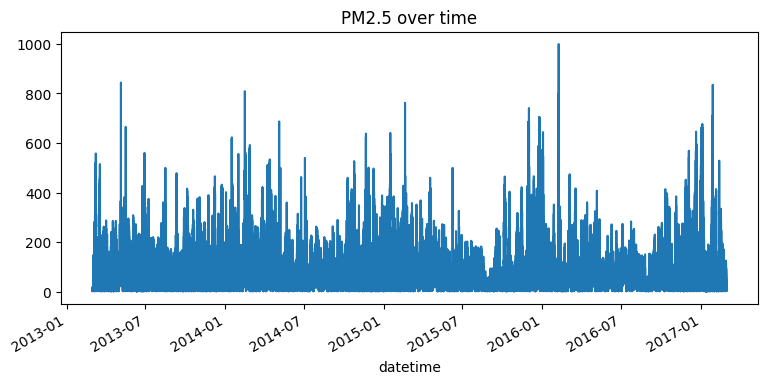

In [41]:
# Cell 3 — Target time series
if TS_COLUMN not in df.columns:
    raise ValueError(f"{TS_COLUMN} not found. Available: {df.columns.tolist()}")

series = pd.to_numeric(df[TS_COLUMN], errors="coerce")
series = series.fillna(method="ffill").fillna(method="bfill")

print(series.describe())
series.plot(title=f"{TS_COLUMN} over time")
plt.show()


In [42]:
df.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,
2013-03-01,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01,1,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Tiantan
2013-03-01,1,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
2013-03-01,1,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Wanliu
2013-03-01,1,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping


Numeric columns: ['No', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
Object columns: ['wd', 'station']


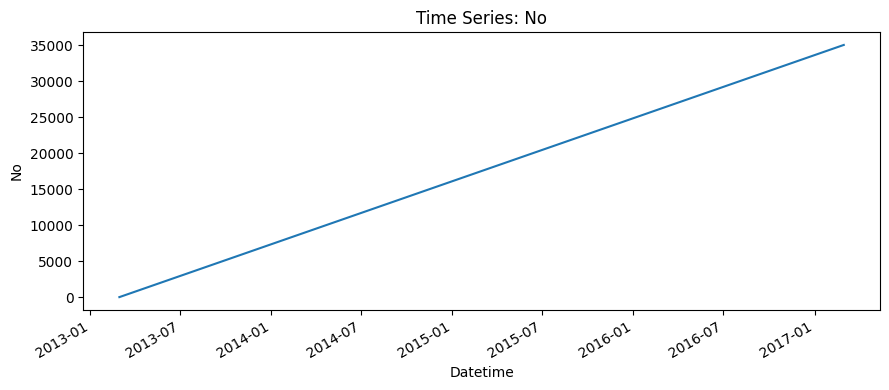

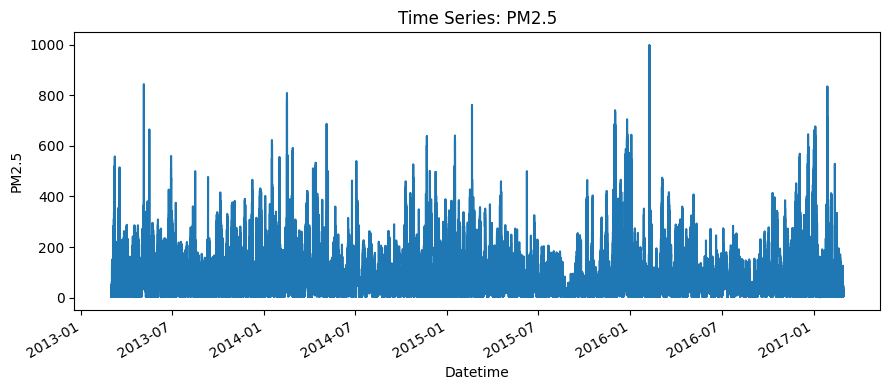

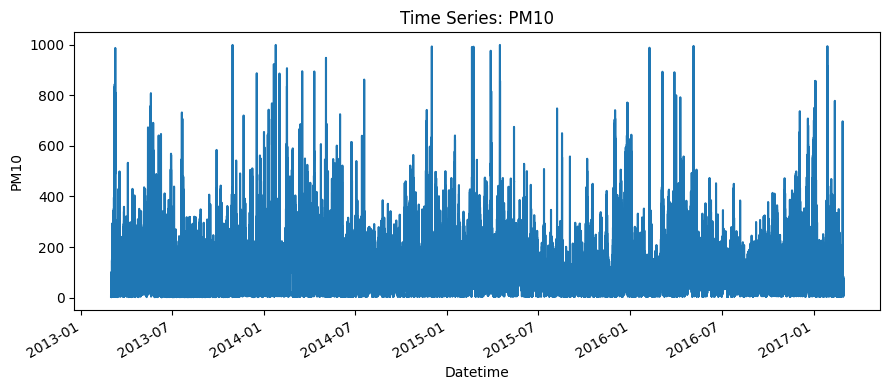

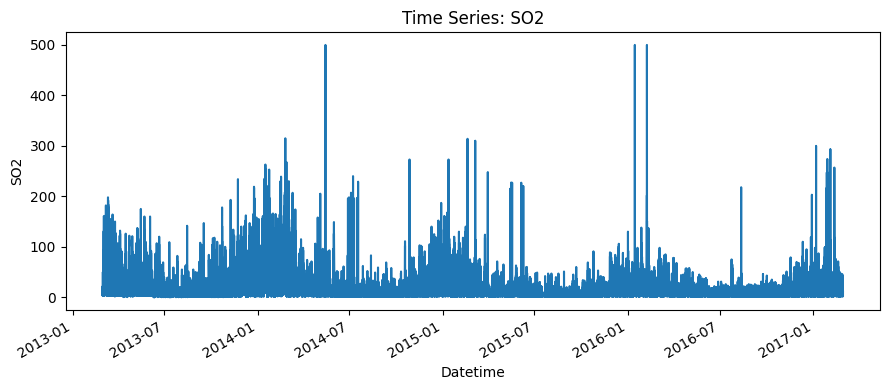

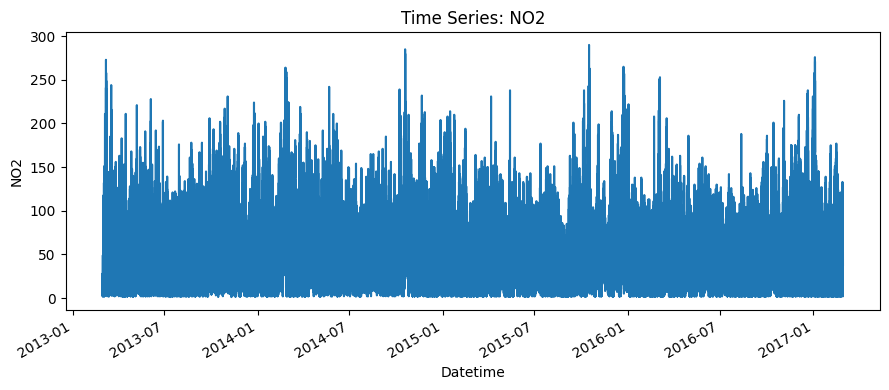

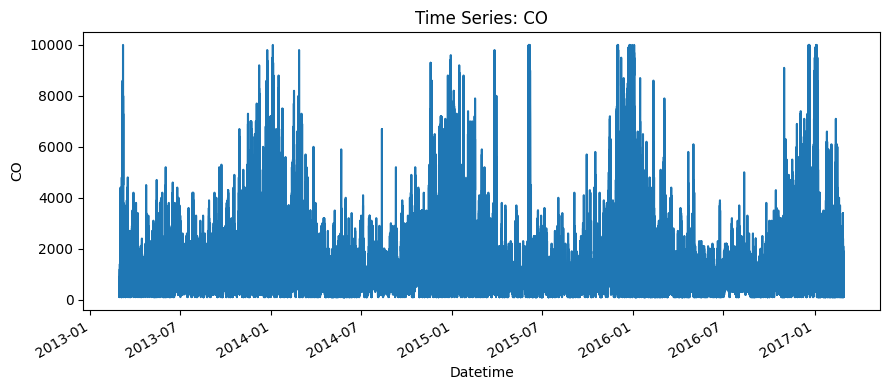

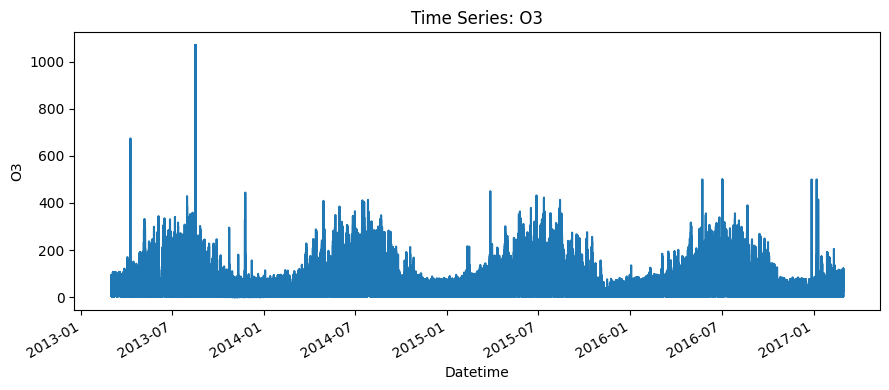

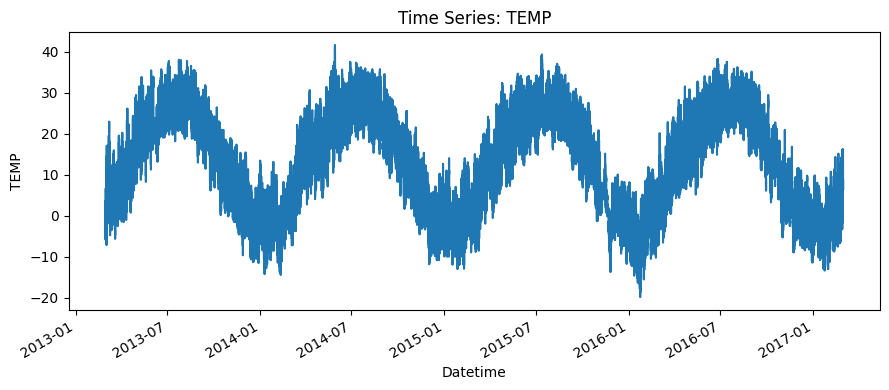

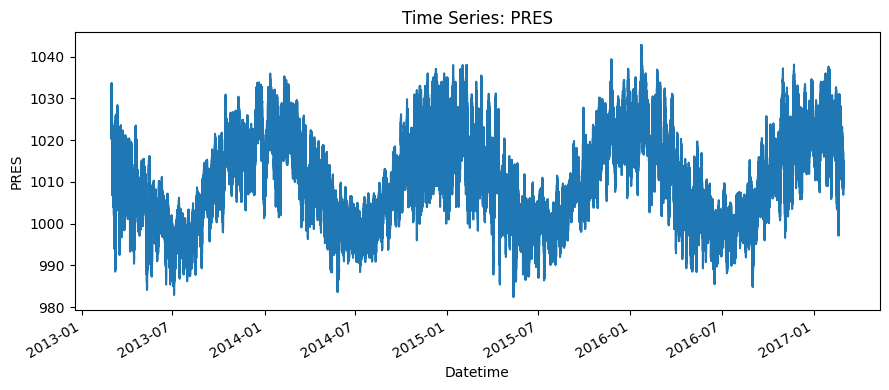

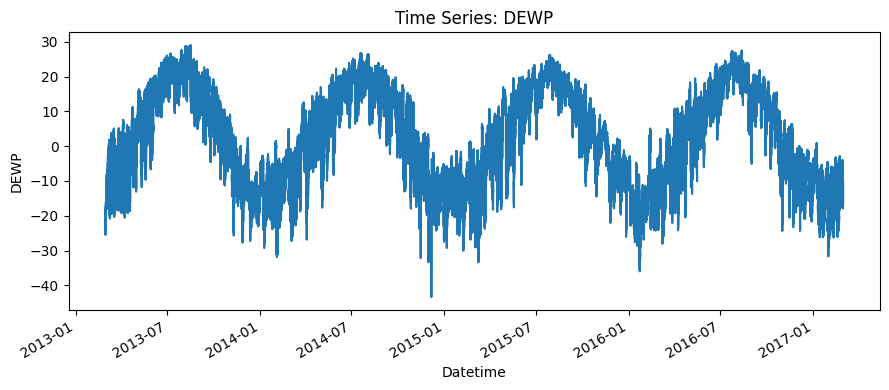

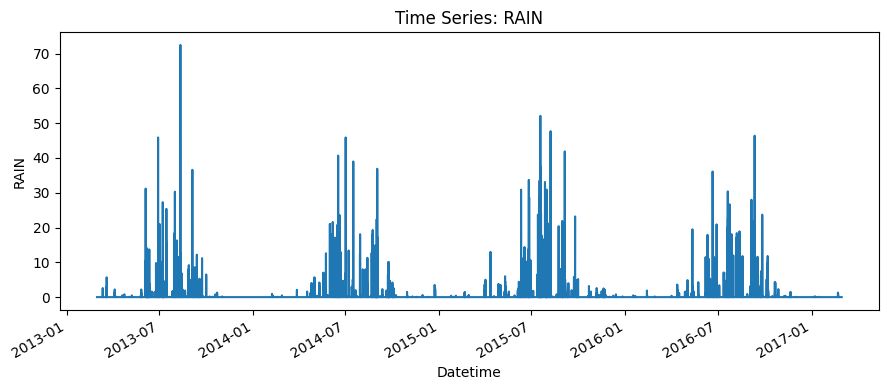

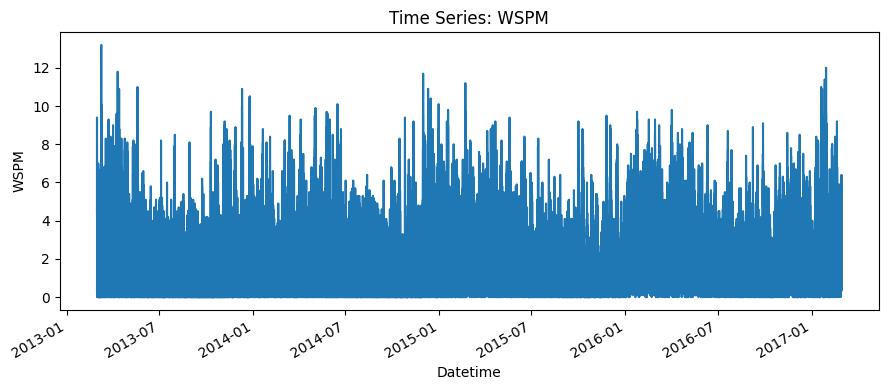

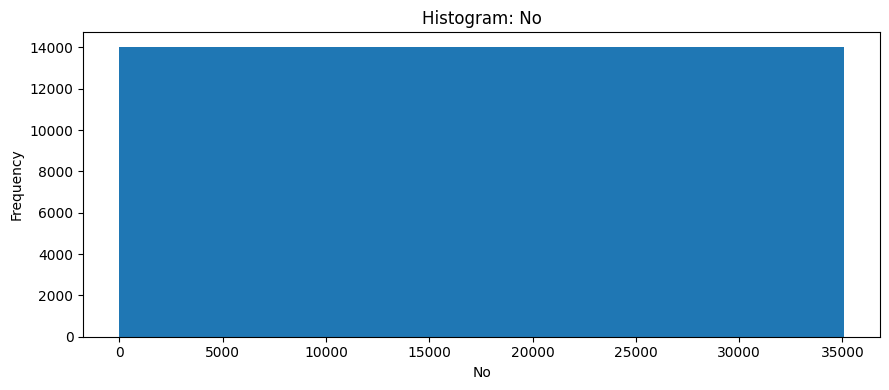

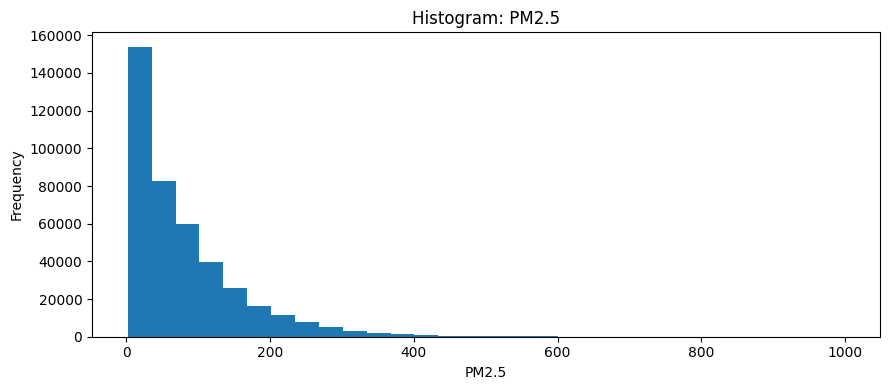

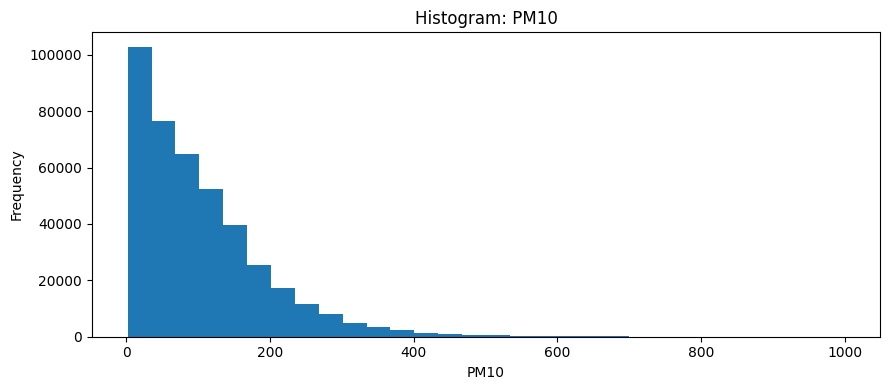

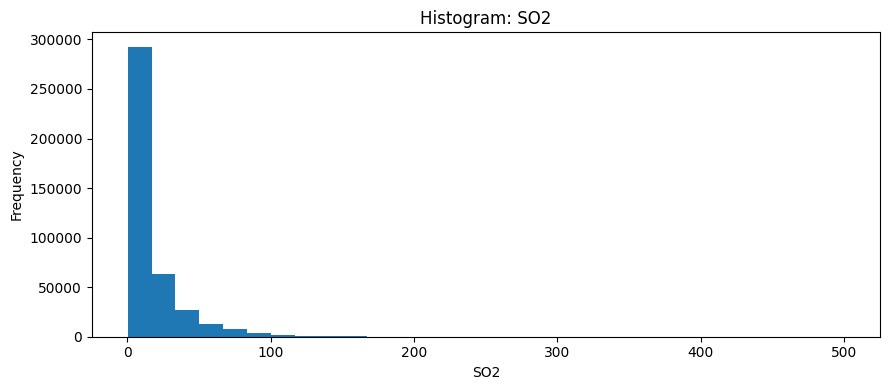

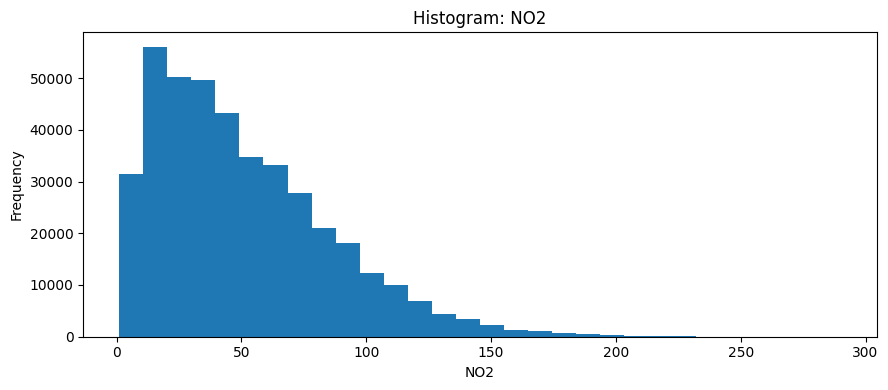

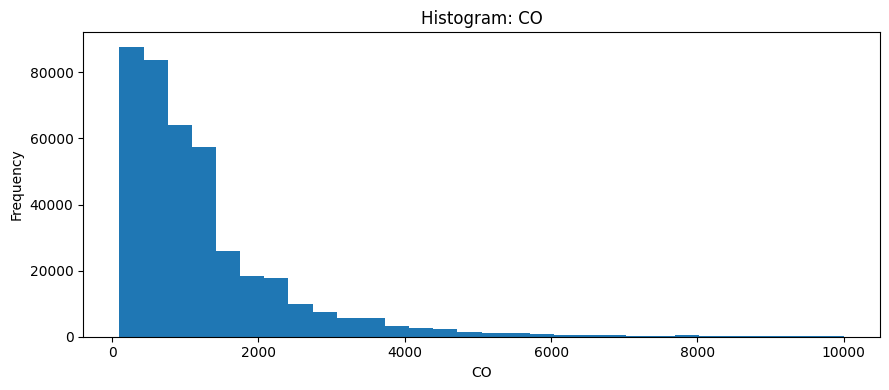

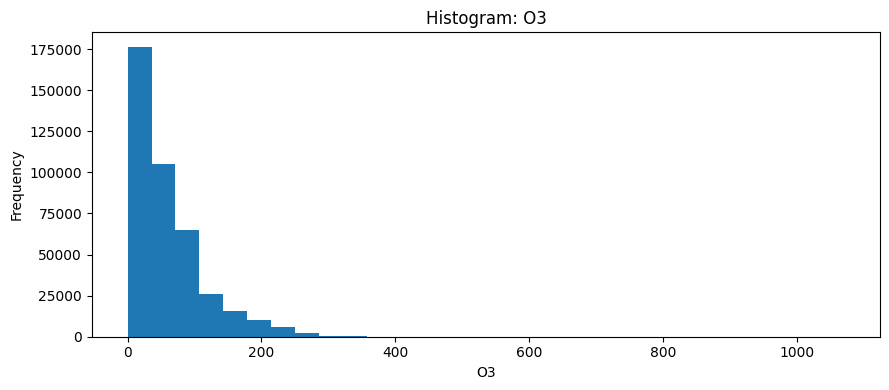

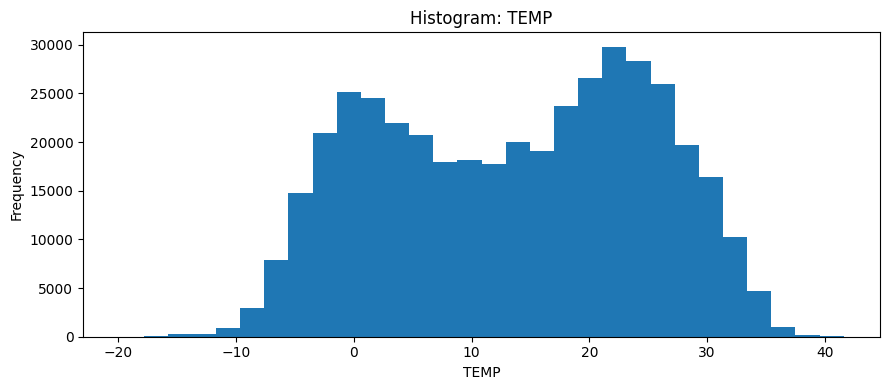

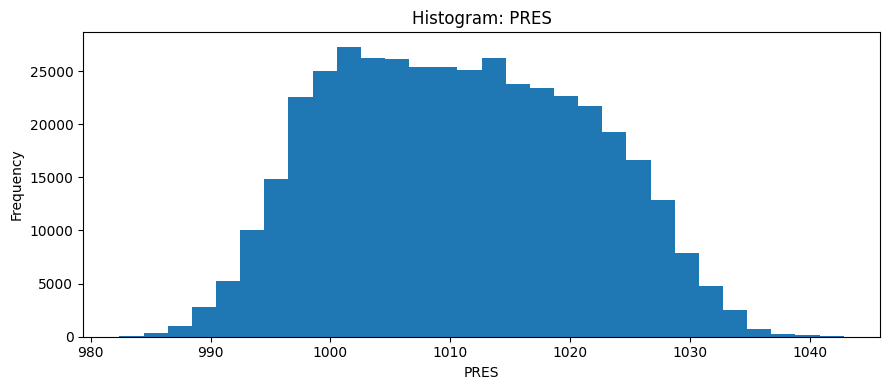

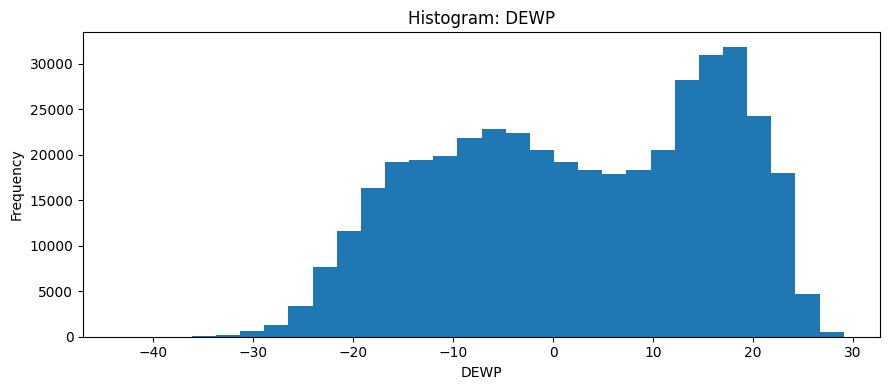

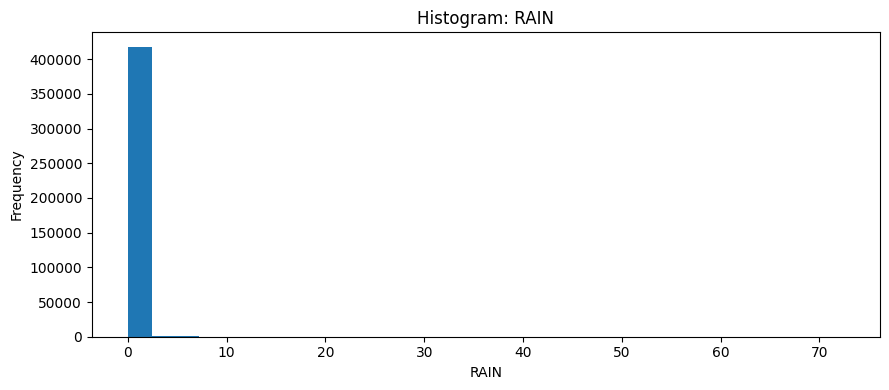

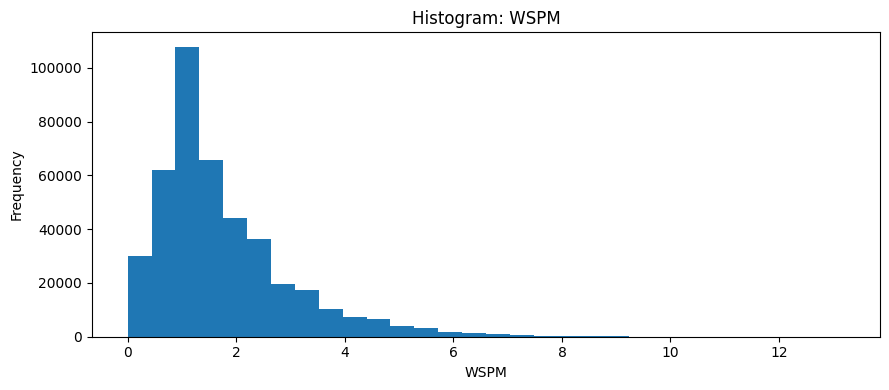

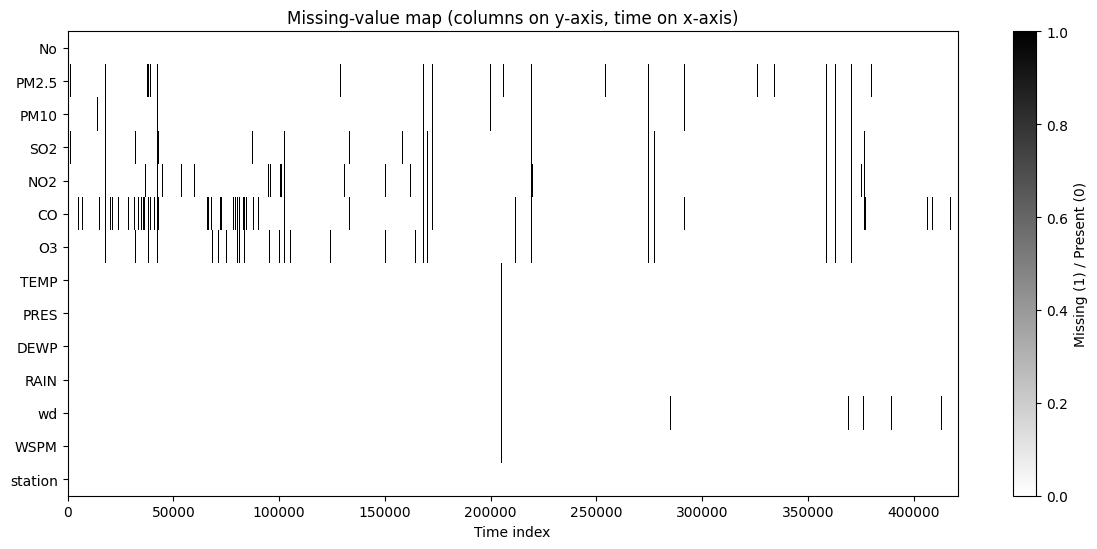

In [43]:
# Cell 4 — Quick visual EDA & histograms

# Separate column types
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
obj_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric columns:", num_cols)
print("Object columns:", obj_cols)

# Time series plots for numeric columns
for c in num_cols:
    plt.figure()
    df[c].dropna().plot()
    plt.title(f"Time Series: {c}")
    plt.ylabel(c)
    plt.xlabel("Datetime")
    plt.tight_layout()
    plt.show()

# Histograms for numeric columns
for c in num_cols:
    plt.figure()
    df[c].dropna().plot(kind='hist', bins=30)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

# Missing-value heatmap across time
plt.figure(figsize=(12, max(3, len(df.columns)*0.4)))
plt.imshow(df.isna().T, aspect='auto', interpolation='none', cmap="gray_r")
plt.yticks(range(len(df.columns)), df.columns)
plt.title("Missing-value map (columns on y-axis, time on x-axis)")
plt.xlabel("Time index")
plt.colorbar(label="Missing (1) / Present (0)")
plt.tight_layout()
plt.show()


In [44]:
# Cell 5 — Augmented Dickey–Fuller test
adf_result = adfuller(series.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, val in adf_result[4].items():
    print(f"Critical value {key}: {val}")


ADF Statistic: -24.574315383948683
p-value: 0.0
Critical value 1%: -3.430365544911031
Critical value 5%: -2.86154687066485
Critical value 10%: -2.56677365700442


In [45]:
df_filled.isna().sum()

No         0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

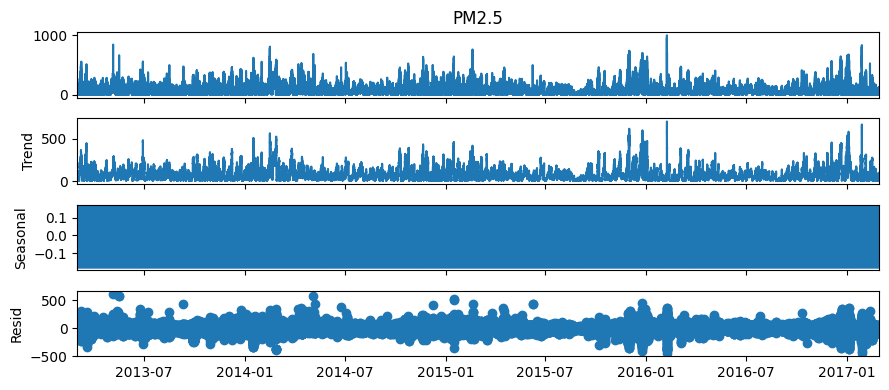

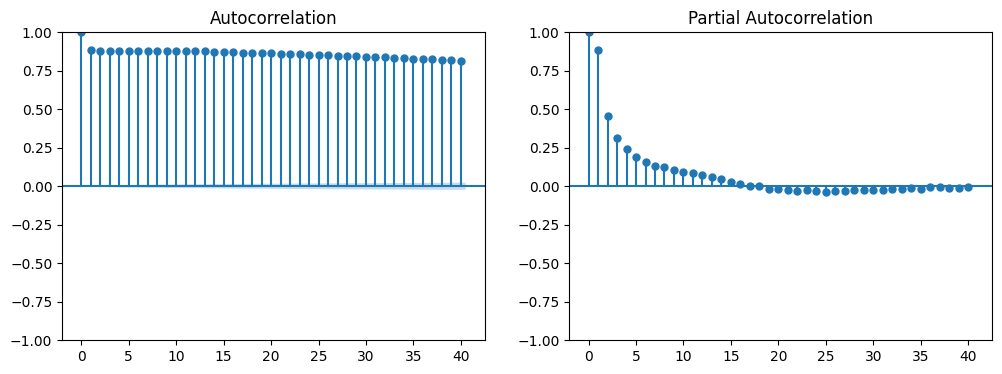

In [46]:
# Cell 6 — Seasonal decomposition + ACF/PACF
try:
    decomposition = seasonal_decompose(series, period=SEASONAL_PERIOD_FALLBACK)
    decomposition.plot()
    plt.show()
except Exception as e:
    print("Seasonal decomposition failed:", e)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(series, ax=axes[0], lags=40)
plot_pacf(series, ax=axes[1], lags=40)
plt.show()


In [ ]:
series = series.asfreq('D') 


In [ ]:
# Cell 7 — ARIMA grid search with freq

results = []
fits = 0
for p in ARIMA_P_RANGE:
    for d in ARIMA_D_RANGE:
        for q in ARIMA_Q_RANGE:
            if fits >= MAX_ARIMA_FITS:
                break
            try:
                model = SARIMAX(series, order=(p,d,q),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                res = model.fit(disp=False)
                results.append(((p,d,q), res.aic))
                fits += 1
            except Exception as e:
                print(f"Skipped (p,d,q)=({p},{d},{q}) due to: {e}")
                continue

results_sorted = sorted(results, key=lambda x: x[1])
print("Top ARIMA candidates (order → AIC):")
for order,aic in results_sorted[:10]:
    print(order, "→", round(aic,2))


Using period: 12


Seasonal component (first rows)

,observed,trend,seasonal,resid
0,4.0,0.274476,2.340589,1.384936
1,8.0,0.720717,1.659665,5.619619
2,7.0,1.166958,0.334445,5.498597
3,6.0,1.613199,-1.393510,5.780311
4,3.0,2.059441,-2.860410,3.800969


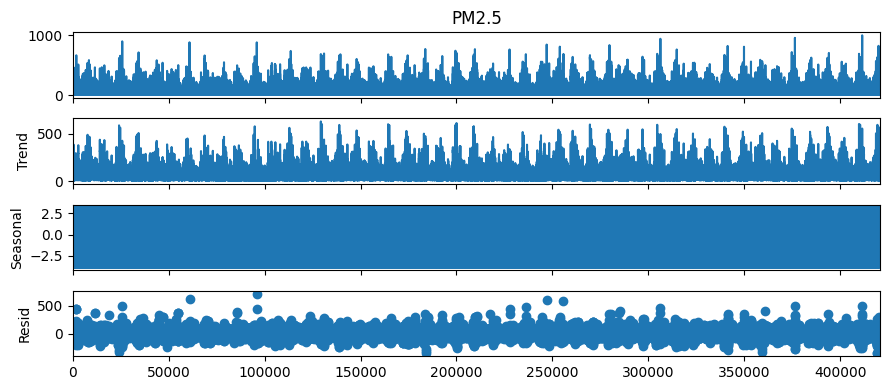

In [ ]:
# Cell 8 — Fit best model from search
best_order = results_sorted[0][0]
print("Best ARIMA order:", best_order)

model = SARIMAX(series, order=best_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())
res.plot_diagnostics(figsize=(10,6))
plt.show()


<Figure size 900x400 with 0 Axes>

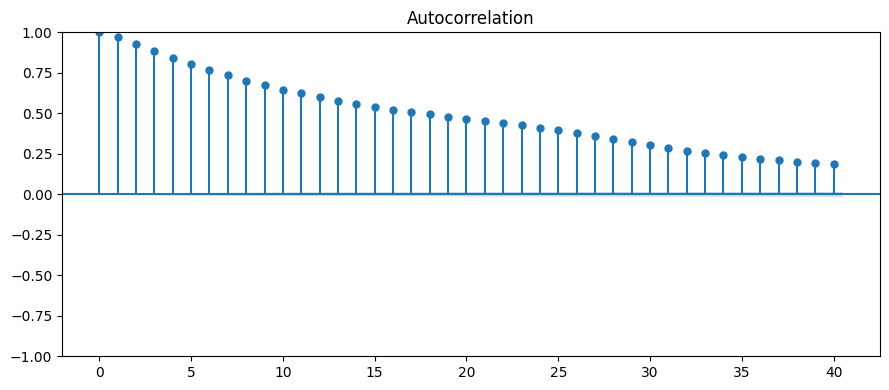

<Figure size 900x400 with 0 Axes>

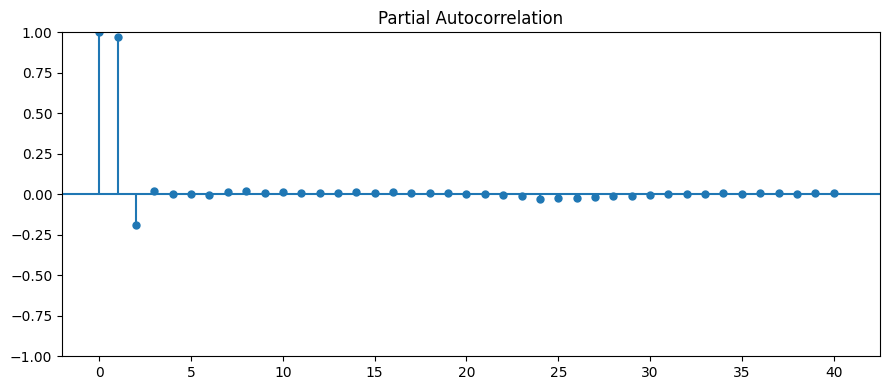

In [ ]:
# Cell 9 — ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(series, lags=min(40, len(series)-1))
plt.tight_layout()
plt.show()

plt.figure()
plot_pacf(series, lags=min(40, len(series)-1), method='ywm')
plt.tight_layout()
plt.show()


In [ ]:
# Cell 10 — Grid search for ARIMA (p,d,q) by AIC — light search by default
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

candidates = list(itertools.product(ARIMA_P_RANGE, ARIMA_D_RANGE, ARIMA_Q_RANGE))
results = []
start = time.time()
fit_count = 0

for order in candidates:
    if fit_count >= MAX_ARIMA_FITS:
        break
    p,d,q = order
    try:
        model = SARIMAX(series, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        results.append(((p,d,q), res.aic))
        fit_count += 1
    except Exception as e:
        # skip bad combinations
        continue

if not results:
    print("No ARIMA models fit successfully in this grid.")
else:
    results_sorted = sorted(results, key=lambda x: x[1])
    print("Top candidates by AIC:")
    for order, aic in results_sorted[:5]:
        print(order, "AIC:", aic)
    best_order, best_aic = results_sorted[0]
    print("Best order:", best_order, "AIC:", best_aic)


Top candidates by AIC:
(2, 1, 2) AIC: 3712498.1873229383
(2, 1, 1) AIC: 3712619.609856183
(1, 1, 2) AIC: 3712698.7244934095
(1, 0, 2) AIC: 3717231.2641578685
(2, 0, 1) AIC: 3717248.722727935
Best order: (2, 1, 2) AIC: 3712498.1873229383


**Model summary (trimmed)**

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:               420768
Model:               SARIMAX(2, 1, 2)   Log Likelihood            -1856244.094
Date:                Tue, 30 Sep 2025   AIC                        3712498.187
Time:                        01:38:34   BIC                        3712552.936
Sample:                             0   HQIC                       3712513.798
                             - 420768                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0691      0.003    417.618      0.000       1.064       1.074
ar.L2         -0.1115      0.003    -43.632      0.000      -0.117      -0.106
ma.L1         -0.9149      0.003   -356.588      0.0

**Diagnostics plots**

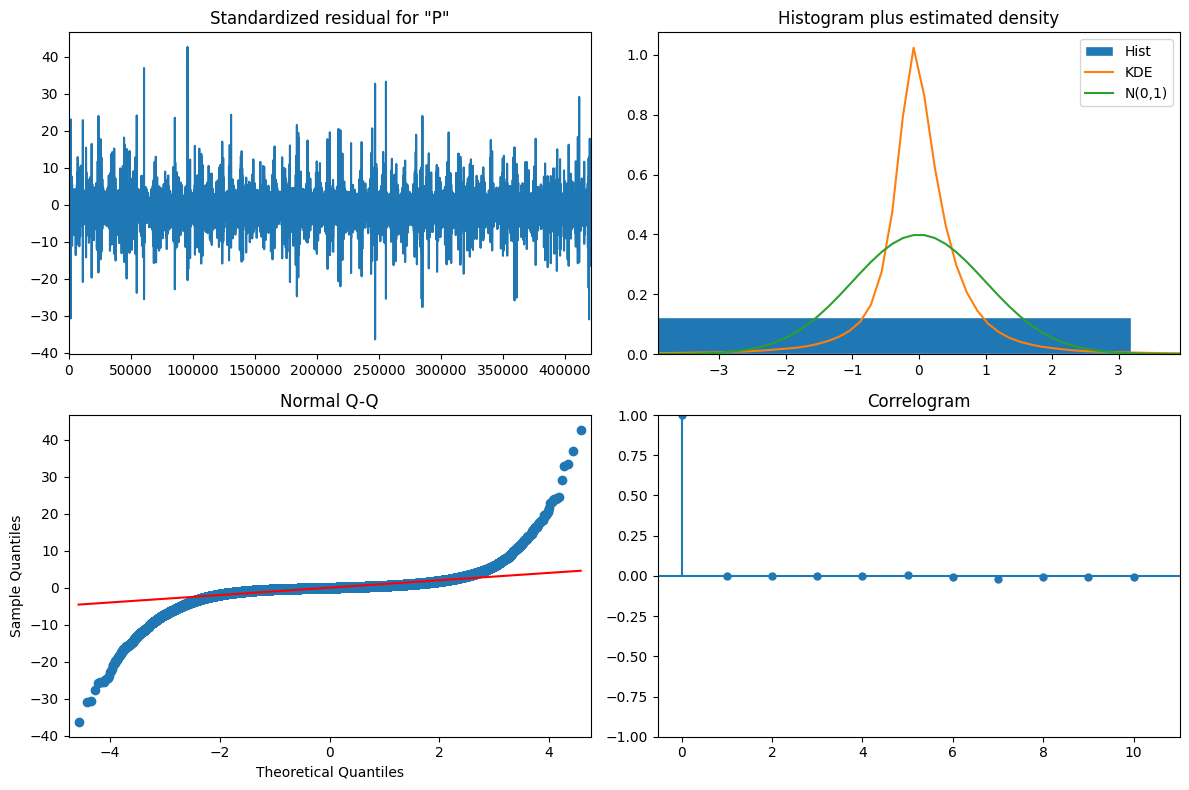

Check residuals: should resemble white noise (no autocorrelation).


In [ ]:
# Cell 11 — Fit the best ARIMA and show diagnostics
if results:
    best_order = results_sorted[0][0]
    model = SARIMAX(series, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    display(Markdown("**Model summary (trimmed)**"))
    print(res.summary())
    print("AIC:", res.aic)
    display(Markdown("**Diagnostics plots**"))
    res.plot_diagnostics(figsize=(12,8))
    plt.tight_layout()
    plt.show()
    print("Check residuals: should resemble white noise (no autocorrelation).")


In [ ]:
# Cell 12 — Short conclusions & suggested next steps
print("Automated conclusions & suggestions:")
if adf_res[1] < 0.05:
    print("- Series appears stationary according to ADF (p < 0.05).")
else:
    print("- Series appears non-stationary according to ADF (p >= 0.05). Consider first-differencing (d=1).")

print(f"- ARIMA search suggested best order {best_order} with AIC {best_aic:.2f} (among search grid).")
print("- Next steps: validate residuals; if seasonal patterns exist, consider SARIMA with seasonal_order.")
print("- If multiple numeric series present, repeat time-series analysis per series or build multivariate models.")


Automated conclusions & suggestions:
- Series appears stationary according to ADF (p < 0.05).
- ARIMA search suggested best order (2, 1, 2) with AIC 3712498.19 (among search grid).
- Next steps: validate residuals; if seasonal patterns exist, consider SARIMA with seasonal_order.
- If multiple numeric series present, repeat time-series analysis per series or build multivariate models.
